# A Predictive Analysis of Restaurant Reviews through Text-Based Classification Modeling
#### ADS 509 Final Project | Team 3 | Saba Alemayehu, John Chen, and Anusia Edward

In [114]:
# necessary imports 
import requests
import pandas as pd
import numpy as np
import json

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

from collections import Counter
from nltk.corpus import stopwords
from string import punctuation
import textacy.preprocessing as tprep
from wordcloud import WordCloud 

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, hamming_loss 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

import warnings
warnings.filterwarnings("ignore")

## Part 1: Data Acquisition through Web Scraping 

In [4]:
# Function to Scrape Yelp Reviews
webdriver_john = '/Users/JohnnyBlaze/drivers/chromedriver'
webdriver_anusia = '/Users/anusiaedward/Downloads/chromedriver_mac_arm64/chromedriver'

def scrape_yelp_pages(url):
    # Set up Chrome driver service
    service = webdriver.chrome.service.Service('chromedriver')  
    service.start()

    # Set up Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  

    # Create a new instance of the Chrome driver
    driver = webdriver.Chrome(service=service, options=options)

    # Navigate to the webpage
    driver.get(url)

    # Wait for the page to load and for the first page number element to be visible
    page_number_element = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.XPATH, '//div[@aria-label="Page: 1"]'))
    )

    reviews = []
    star_ratings = []
    dates = []

    while True:
        # Process the current page here
        review_elements = driver.find_elements(By.XPATH, '//span[@class=" raw__09f24__T4Ezm" and @lang="en"]')
        star_rating_elements = driver.find_elements(By.XPATH, '//div[contains(@aria-label, "star rating")]')
        date_elements = driver.find_elements(By.XPATH, '//span[@class=" css-chan6m"]')

        for review_element, star_rating_element, date_element in zip(review_elements, star_rating_elements, 
                                                                     date_elements):
            review_text = review_element.text
            star_rating = star_rating_element.get_attribute('aria-label')
            date = date_element.text

            # Ignore dates with the words 'Photos', 'years', 'Photo', and 'year'
            if 'Photos' not in date and 'years' not in date and 'Photo' not in date and 'year' not in date:
                reviews.append(review_text)
                star_ratings.append(star_rating)
                dates.append(date)

        try:
            # Click on the next page
            next_page_arrow = driver.find_element(By.XPATH, '//span[@class="icon--24-chevron-right-v2\
            navigation-button-icon__09f24__Bmrde css-1kq79li"]')
            next_page_arrow.click()

            # Wait for a brief moment for the new review elements to load
            WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.XPATH, '//span[@class="\
            raw__09f24__T4Ezm" and @lang="en"]')))

        except:
            # Break the loop when there are no more pages to click
            break

    # Close the browser window
    driver.quit()

    # Create a DataFrame with the scraped data
    data = pd.DataFrame({'Date': dates, 'Review': reviews, 'Star Rating': star_ratings})

    return data

In [5]:
# Filippi's Pizza

pizza_df = scrape_yelp_pages('https://www.yelp.com/biz/filippis-pizza-grotto-mission-valley-san-diego?osq=pizza')

pizza_df.head()

,Date,Review,Star Rating
0,1/19/2023,We loved every meal we have ever tried at Fili...,5 star rating
1,1/18/2023,I ordered a basil and cheese pizza and it is p...,1 star rating
2,6/4/2023,"This is my Kids FAV pizza in town. Yes, it may...",5 star rating
3,6/6/2023,You've never had a good pizza till you've had ...,5 star rating
4,10/27/2022,"Fast service, Eddie was very efficient and kin...",5 star rating


In [7]:
# To CSV

csv_file_path = 'filippi.csv'

pizza_df.to_csv(csv_file_path, index=False)

In [6]:
# Tacos El G

taco_df = scrape_yelp_pages('https://www.yelp.com/biz/tacos-el-g-national-city-7?osq=Tacos')

taco_df.head()


,Date,Review,Star Rating
0,5/2/2023,Not good there is this weird tasting sauce the...,5 star rating
1,3/14/2023,It really could have been better because I am ...,4 star rating
2,2/19/2023,Tacos are good.\nPrices were raised though so ...,1 star rating
3,4/7/2023,"tacos had no flavor,meat was greasy and tough....",5 star rating
4,3/13/2022,Late night stop with my cousin! Neither of us ...,5 star rating


In [10]:
# To CSV

csv_file_path = 'taco_el_g.csv'

taco_df.to_csv(csv_file_path, index=False)

## Part 2: Preprocessing & Exploratory Data Analysis

In [2]:
# accessing the data 
pizza_df = pd.read_csv('filippi.csv')
taco_df = pd.read_csv('taco_el_g.csv')

In [3]:
# doubling checking that data was pulled correctly 
print("Shape of Pizza Data: ", pizza_df.shape)
print("Shape of Taco Data: ", taco_df.shape)

Shape of Pizza Data:  (239, 3)
Shape of Taco Data:  (546, 3)


In [4]:
# checking for null values 
print("Null Values Present in Pizza Data: ")
pizza_df.isnull().sum()

Null Values Present in Pizza Data: 


Date           0
Review         0
Star_Rating    0
dtype: int64

In [5]:
print("Null Values Present in Taco Data: ")
taco_df.isnull().sum()

Null Values Present in Taco Data: 


Date           0
Review         0
Star_Rating    0
dtype: int64

In [6]:
# checking datatype for each of the variables within the data 
print("Datatypes Present in Pizza Data: ")
pizza_df.dtypes

Datatypes Present in Pizza Data: 


Date           object
Review         object
Star_Rating    object
dtype: object

In [7]:
print("Datatypes Present in Taco Data: ")
taco_df.dtypes

Datatypes Present in Taco Data: 


Date           object
Review         object
Star_Rating    object
dtype: object

In [8]:
#renaming columns
pizza_df.rename(columns = {'Star Rating':'Star_Rating'}, inplace = True)
taco_df.rename(columns = {'Star Rating':'Star_Rating'}, inplace = True)

In [9]:
# fixing the formatting in the "Star_Rating" column for pizza df  
pizza_df['Star_Rating'] = pizza_df.Star_Rating.str.extract('(\d+)')

# checking 
pizza_df.head(3)

,Date,Review,Star_Rating
0,1/19/23,You've never had a good pizza till you've had ...,5
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5


In [10]:
# fixing the formatting in the "Star_Rating" column for taco df  
taco_df['Star_Rating'] = taco_df.Star_Rating.str.extract('(\d+)')

# checking 
taco_df.head(3)

,Date,Review,Star_Rating
0,5/2/23,It really could have been better because I am ...,4
1,3/14/23,Tacos are good.\nPrices were raised though so ...,1
2,2/19/23,Late night stop with my cousin! Neither of us ...,5


In [11]:
# adding the resturant name to each dataset -> ease of differentiation when combining later 
pizza_df['Restaurant'] = "pizza"
taco_df['Restaurant'] = "taco"

# checking 
display(pizza_df.head(3), taco_df.head(3))

,Date,Review,Star_Rating,Restaurant
0,1/19/23,You've never had a good pizza till you've had ...,5,pizza
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1,pizza
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5,pizza


,Date,Review,Star_Rating,Restaurant
0,5/2/23,It really could have been better because I am ...,4,taco
1,3/14/23,Tacos are good.\nPrices were raised though so ...,1,taco
2,2/19/23,Late night stop with my cousin! Neither of us ...,5,taco


In [12]:
# merging the dataframes 
pt_df = pd.concat([pizza_df, taco_df],    # Combine vertically
                          ignore_index = True,
                          sort = False)

# checking that nothing was lost -> total should be 785 (Pizza = 239 + Tacos = 546)
print("Shape of Combined Data: ", pt_df.shape)

Shape of Combined Data:  (785, 4)


In [13]:
# changing star_rating to int otherwise will obtain the following error for the next step: 
# TypeError: '>=' not supported between instances of 'str' and 'int'
pt_df['Star_Rating'] = pt_df['Star_Rating'].astype(str).astype(int)

# adding a customer sentiment towards to resturant based on the star rating recieved 
pt_df['Customer_Sentiment'] = np.where(pt_df['Star_Rating'] >= 3, 'positive', 'negative')

# checking 
pt_df.head(3)

,Date,Review,Star_Rating,Restaurant,Customer_Sentiment
0,1/19/23,You've never had a good pizza till you've had ...,5,pizza,positive
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1,pizza,negative
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5,pizza,positive


In [14]:
# reorganizing column order for ease of use 
pt_df = pt_df.reindex(columns=['Date', 'Star_Rating', 'Restaurant', 
                               'Customer_Sentiment', 'Review'])

# checking 
pt_df.head(1)

,Date,Star_Rating,Restaurant,Customer_Sentiment,Review
0,1/19/23,5,pizza,positive,You've never had a good pizza till you've had ...


In [28]:
# cleaning/tokenizing/normalizing/pattern functions: 

# punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# stopwords
sw = stopwords.words("english")
# sw.extend(["tacos"])

# helper functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    num_tokens = len(tokens) 
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print("The top 5 most common tokens")
        print(Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

def remove_stop(tokens) :
    return[i for i in tokens if i.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    text = text.split()
    return(text)

def normalize(text): 
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text 

def detokenize(text):
    return(" ".join([str(i) for i in text]))

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

# cleaning pipeline: case folding, fixing punctuation, tokenizing, and removing stopwords 
clean_pipe = [str.lower, remove_punctuation, tokenize, remove_stop]
# additional pipe: case folding, normalize fixing punctuation, tokenizing, removing stopwords, 
# and detokenizing for modeling
clean_pipes = [str.lower, normalize, remove_punctuation, tokenize, remove_stop, detokenize]

In [29]:
# applying pipeline
pt_df["tokens"] = pt_df["Review"].apply(prepare,pipeline=clean_pipe)
pt_df["clean"] = pt_df["Review"].apply(prepare,pipeline=clean_pipes)
pt_df["num_tokens"] = pt_df["tokens"].map(len) 

# using textblot to calculate sentiment polarity [-1, 1]: 1=+, -1=-, 0=neutral
pt_df['polarity'] = pt_df['Review'].map(lambda text: TextBlob(text).sentiment.polarity)

# check 
pt_df.head(5)

,Date,Star_Rating,Restaurant,Customer_Sentiment,Review,tokens,clean,num_tokens,polarity
0,1/19/23,5,pizza,positive,You've never had a good pizza till you've had ...,"[youve, never, good, pizza, till, youve, pizza...",youve never good pizza till youve pizza always...,17,0.477778
1,1/18/23,1,pizza,negative,"This is my Kids FAV pizza in town. Yes, it may...","[kids, fav, pizza, town, yes, may, 2x, 3x, cos...",kids fav pizza town yes may 2x 3x costco acros...,55,0.013636
2,12/4/22,5,pizza,positive,I ordered a basil and cheese pizza and it is p...,"[ordered, basil, cheese, pizza, phenomenal, ch...",ordered basil cheese pizza phenomenal cheese d...,34,0.600000
3,8/26/16,5,pizza,positive,"Myself, and my dear Friend and her daughter vi...","[dear, friend, daughter, visited, may, 13, lat...",dear friend daughter visited may 13 late after...,53,-0.059167
4,2/13/15,4,pizza,positive,Me and my co-workers went to this location for...,"[coworkers, went, location, first, time, picke...",coworkers went location first time picked food...,29,-0.069444


In [30]:
# Looking at the Reviews associated with Positive Sentiment 
print('5 random Reviews with the Highest Positive Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == 1, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Positive Sentiment Polarity: 

I ordered 2 or the tacos de asada.
The beef was a bit too chewy for me, but the freshness and flavor was great! I was craving tacos, so this hit the spot!
Tacos de Adobado are delicious, also recommend their quesadillas.
Best place for tacos practically any time of the day. Adobado with both kinds of guacamole is the best
Best tacos I have ever had ! I tried adobada and carne Asada tacos and they were delicious..
Always on point wether for lunch or at 3 in the morning after the club but the cabeza and lengua  tacos are always on point the best drink food ever about as close as you can get to Tj street tacos after a night of partying


In [31]:
# Looking at the Reviews associated with Neutral Sentiment 
print('5 random Reviews with the Highest Neutral Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == 0, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Neutral Sentiment Polarity: 

The tacos are Bombay.  These closest street tacos you can find without crossing the border.
On sat 1-25-2014 just found two hairs in our tacos one in asada and one in a tripa tacos so you tell me.... buyer beware hairy food....
I'm not a big fan of Mexican food, but I'd drive 100 miles south for some Adobada tacos from Tacos El Gordo! That's all I can say.
Closest thing to T.J. tacos!! The mulitas are my fav! I am a simple girl so I only like them with guac. Now I want some T.J. tacos damn it!! Border run anyone?
Salí de trabajar cansado y con hambre ordene y todo bien y luego fui a ordenar la comida y recibieron mi ticket esperando mi comida pasaron 20 minutos y nunca me hicieron mi comida, siempre vengo aquí y es la primera vez que el servicio está pa la chingada no se que estaba pasando pero no modo voy para otro lado para taco Tuesday


In [32]:
# Looking at the Reviews associated with Negative Sentiment 
print('5 random Reviews with the Highest Negative Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == -0.3, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Negative Sentiment Polarity: 

Stood there for twenty minutes and could not get service because of their poor line system and inattentive chefs. Left with nada. Disappointing and a waste of time.
the crust was thick with no taste.  the sauce was lacking. no flavor.
I am a huge pizza fan and had pizza from places all over the country as I travel often.  this is the worst.
I WISH I COULD GIVE 0 STARS! This place sucked! DO NOT GO HERE! Unless you like burnt and cold food. It also smelled summer gross inside
Horrible service!!! I guess this place is not a tacos el gordo location anymore... I ordered to go. They made me wait forever to get four tacos. I was not given lemons or radishes with my order. I went inside and the lady said that they only provide with lemons and radishes if I request them. Really?? How am I supposed to know that?? It is a to go order lady... what about asking customers or posting a sign by the drive through window...no common sense

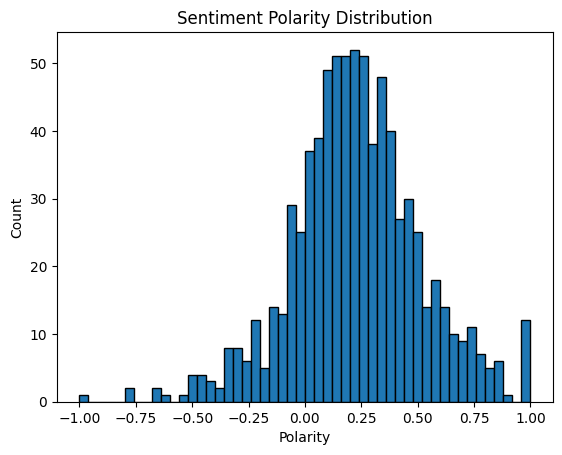

In [33]:
# distribution of polarity
plt.hist(data=pt_df, x="polarity", bins = 50, edgecolor='black')
plt.title("Sentiment Polarity Distribution")
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

Sentiment analysis is a technique used to determine whether data is positive, negative or neutral. More specifically, it is essentially a natural language processing (NLP) technique that can be used to monitor the polarity of customer feedback. The TextBlob (a simple python library for NLP) library was employed in order to determine the polarity of the restaurant customer reviews. Looking at the polarity distribution obtained, it is evident that there are more positive sentiments than negative. This can be verified through the graph seen above, which displays a right skewed distribution (higher frequency of polarity values greater than zero). It should be noted that positive reviews are indicated by polarity values above zero, neutral reviews are indicated by polarity values at zero, and negative reviews are indicated by polarity values less than zero.

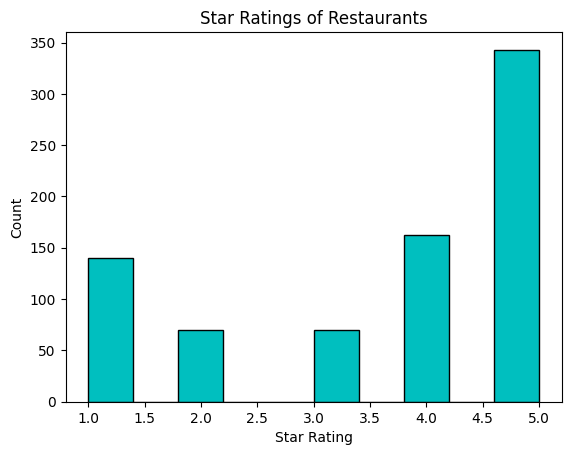

In [34]:
# distribution of star_rating 
plt.hist(data=pt_df, 
         x="Star_Rating", 
         bins = 10,
        facecolor='c',
        edgecolor='black')
plt.title("Star Ratings of Restaurants")
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

Star ratings indicate customer satisfaction. The ratings are given on a scale of 1-5, with 1 indicating low satisfaction and 5 indicating high satisfaction. Looking at the star rating graph above, it is evident that the ratings align with the polarity score distribution seen in the previous plot. This is the case as there is a high frequency of 5 star ratings.

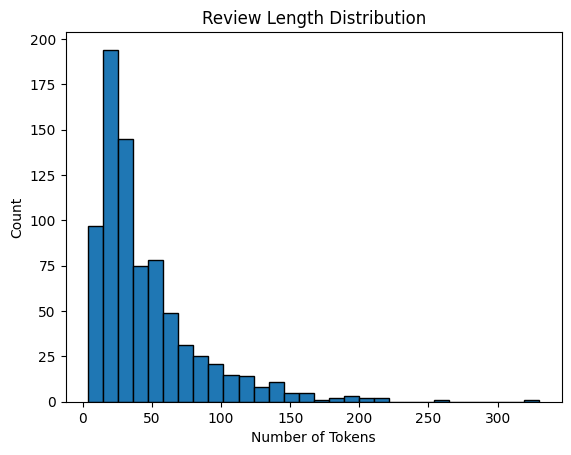

In [35]:
# distribution of review text lengths 
plt.hist(data=pt_df, x="num_tokens", bins = 30, edgecolor='black')
plt.title("Review Length Distribution")
plt.xlabel('Number of Tokens')
plt.ylabel('Count')
plt.show()

Looking at the graph above for the length of the restaurant reviews, it is evident that the distribution is heavily right skewed. This indicates that the majority of restaurant reviews are around twenty-five words. More specifically, most of the restaurant reviews (one hundred-sixty reviews) were about twenty-five words long. The largest restaurant review is a little over two-hundred, while the smallest restaurant review is around ten words.

Customer_Sentiment
negative    AxesSubplot(0.125,0.11;0.775x0.77)
positive    AxesSubplot(0.125,0.11;0.775x0.77)
Name: num_tokens, dtype: object

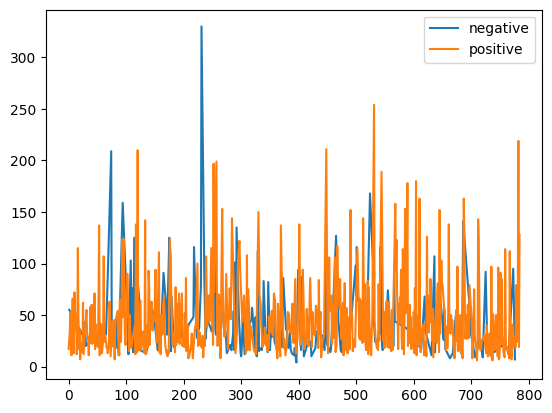

In [36]:
# distribution of review word count 
pt_df.groupby('Customer_Sentiment')['num_tokens'].plot(legend=True)

The line plot above displays the distribution of a customer's sentiments towards the restaurant in accordance with the number of words per restaurant review. The blue line indicates customers that had a negative sentiment towards the restaurant, while the orange line indicates customers that had a positive sentiment towards the restaurant. Looking at the graph, it is evident that there is no clear trend. More specifically, the type of sentiment towards a restaurant (postive or negative) does not seem to have an affect on the written length of the restaurant review.

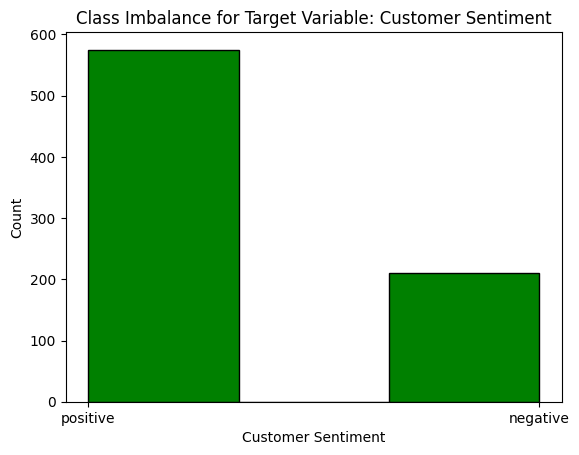

In [37]:
# distribution of positive vs negative reviews 
plt.hist(data=pt_df, 
         x="Customer_Sentiment", 
         bins = 3,
        facecolor='green',
        edgecolor='black')
plt.title("Class Imbalance for Target Variable: Customer Sentiment")
plt.xlabel('Customer Sentiment')
plt.ylabel('Count')
plt.show()

The customer sentiment variable indicates whether the customer feels positively or negatively towards the restaurant. In the plot above, it shows that there are more positive reviews than negative reviews. Based on this, it is evident that there is a class imbalance that should be noted.

In [38]:
# descriptive stats for positive vs negative reviews 

# defining a fxn to pull the descriptive stats 
def f_descriptive_stats(li):
    w_l = [i for s in li for i in s]
    return descriptive_stats(w_l)

# descriptive stats for positive reviews
print("\n Descriptive Stats: Positive Reviews \n")
f_descriptive_stats(pt_df[pt_df['Customer_Sentiment']=='positive']['tokens'])

# descriptive stats for negative reviews 
print("\n Descriptive Stats: Negative Reviews \n")
f_descriptive_stats(pt_df[pt_df['Customer_Sentiment']=='negative']['tokens'])


 Descriptive Stats: Positive Reviews 

There are 26457 tokens in the data.
There are 4111 unique tokens in the data.
There are 140675 characters in the data.
The lexical diversity is 0.155 in the data.
The top 5 most common tokens
[('tacos', 813), ('food', 297), ('good', 286), ('place', 281), ('taco', 255)]

 Descriptive Stats: Negative Reviews 

There are 9503 tokens in the data.
There are 2434 unique tokens in the data.
There are 50865 characters in the data.
The lexical diversity is 0.256 in the data.
The top 5 most common tokens
[('tacos', 250), ('place', 114), ('food', 106), ('good', 99), ('get', 78)]


[9503, 2434, 0.25612964327054616, 50865]

Looking at the descriptive statistics for both the positive and negative reviews, it is evident that there are some similarities as well as differences among the reviews. First, it is evident that there are more tokens and unique tokens for positive reviews than negative reviews. Even through the positive reviews had more tokens and unique tokens, a higher lexical diversity was noted for the negative reviews. This indicates that the proportion of unique tokens to total tokens was greater for the negative reviews than the positive reviews. Another interesting thing to note is that the top five most common tokens for positive and negative restaurant reviews are fairly similar. Both have the words "tacos", "place", and "food". This makes sense as those are the key things that people look into as determining factors of positive or negative experiences.

In [39]:
# wordcloud function obtained from Blueprints for Text Analytics Using Python textbook
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

WORDCLOUD FOR POSITIVE REVIEWS


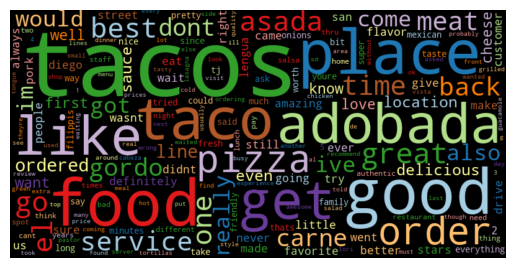

In [40]:
# positive reviews wordcloud
positive_lcount = count_words(pt_df[pt_df['Customer_Sentiment']=='positive'])
print('WORDCLOUD FOR POSITIVE REVIEWS')
wordcloud(positive_lcount.squeeze())

WORDCLOUD FOR NEGATIVE REVIEWS


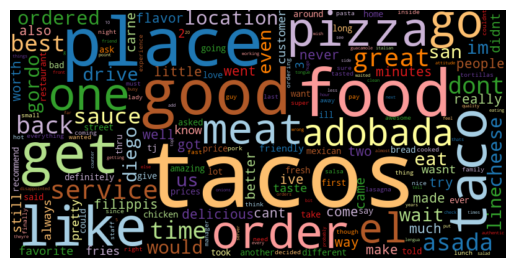

In [41]:
# negative reviews wordcloud
neg_lcount = count_words(pt_df[pt_df['Customer_Sentiment']=='negative'])
print('WORDCLOUD FOR NEGATIVE REVIEWS')
wordcloud(neg_lcount.squeeze())

The word clouds accurately reflect what was determined in the descriptive statistics for both positive and negative restaurant reviews. Looking at the wordcloud for the positive reviews, the words that stick out are "good", "pizza", "great", "best", "food", "tacos", "like", "adobada", and "place". This makes sense as these are positive words associated with the foods that are sold at the restaurants. For the negative reviews wordcloud, the words that stick out are "tacos", "order", "don’t", "food", "good", "place", and "service". This makes sense as they are words that can be used to describe people’s negative experiences. Especially the word "service", for example, is something that can be of concern for people and usually is referenced when people are not happy with how they were treated at the restaurant. Even with the word "good" showing up, it could indicate that the person is saying that it is not good. If you continue to look at the wordcloud, it is evident that there are words like "don’t", reflecting the dissatisfaction with the restaurant by the customer.

## Part 3: Modeling and Model Evaluations 

### Topic Modeling + Evaluations

In [46]:
# display topic function (this function comes from the BTAP repo.)
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [47]:
# TF-IDF and Count Vectorizations 
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), 
                                        min_df=5, 
                                        max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(pt_df["clean"])
count_text_vectors.shape

(785, 991)

In [48]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), 
                                        min_df=5, 
                                        max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(pt_df['clean'])
tfidf_text_vectors.shape

(785, 991)

In [49]:
# Non-Negative Matrix Factorization Model 
nmf_model = NMF(n_components=5,
               random_state = 1025)
w_nmf = nmf_model.fit_transform(tfidf_text_vectors)
h_nmf = nmf_model.components_

In [51]:
display_topics(nmf_model, tfidf_text_vectorizer.get_feature_names_out(),
              no_top_words=10)


Topic 00
  tacos (2.57)
  adobada (2.04)
  taco (2.04)
  asada (1.84)
  carne (1.55)
  meat (1.23)
  line (1.06)
  good (1.02)
  order (0.86)
  pork (0.78)

Topic 01
  pizza (7.63)
  cheese (2.70)
  filippis (1.34)
  sauce (1.17)
  lasagna (1.13)
  cheesy (1.07)
  ordered (1.02)
  love (0.99)
  good (0.96)
  like (0.86)

Topic 02
  best (9.05)
  san (6.97)
  diego (6.88)
  place (3.26)
  ive (2.97)
  tacos (2.50)
  hands (1.99)
  authentic (1.41)
  street (1.20)
  favorite (1.16)

Topic 03
  food (3.08)
  great (2.63)
  service (2.46)
  lori (1.15)
  place (0.93)
  server (0.92)
  good (0.89)
  customer (0.88)
  time (0.83)
  came (0.82)

Topic 04
  tacos (8.46)
  el (7.56)
  gordo (6.42)
  vista (1.55)
  better (1.52)
  chula (1.47)
  like (1.15)
  place (1.03)
  good (1.00)
  drive (0.81)


<AxesSubplot: title={'center': 'Review Count by Category'}, xlabel='Category', ylabel='Review'>

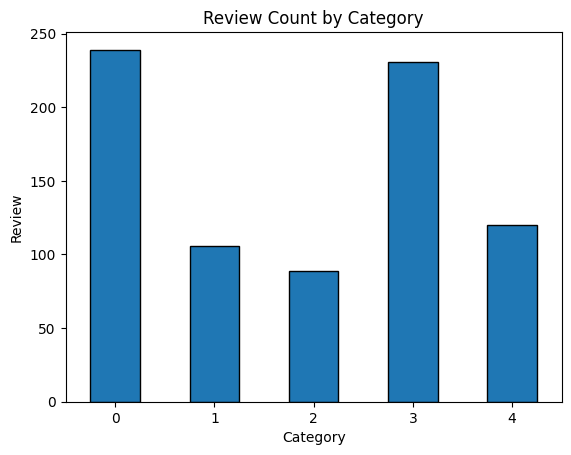

In [60]:
# NMF Model Eval  
# pulling predicted topics from NMF Model 
nmf_predi = [np.argsort(each)[::-1][0] for each in w_nmf]
# adding findings to df 
pt_df2 = pt_df.copy()
pt_df2['nmf_predi'] = nmf_predi 
# plotting results of NMF Model 
ax = (pt_df2.groupby('nmf_predi').size()).plot(kind='bar',
                                              stacked=True,
                                              rot=0,
                                              title='Review Count by Category',
                                              edgecolor='black')
ax.set_xlabel("Category")
ax.set_ylabel("Review")
display(ax)

In [55]:
# LSA Model aka Truncated SVD Model 
# this code was based on the code provided in the BTAP repo link above under the "TruncatedSVD" section
lsa_model = TruncatedSVD(n_components = 5,
                         random_state=1025)
w_lsa = lsa_model.fit_transform(tfidf_text_vectors)
h_lsa = lsa_model.components_

In [57]:
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out(),
              no_top_words=10)


Topic 00
  tacos (2.55)
  place (1.07)
  good (0.99)
  taco (0.97)
  adobada (0.95)
  el (0.92)
  food (0.87)
  best (0.84)
  asada (0.77)
  gordo (0.75)

Topic 01
  pizza (7.22)
  food (3.14)
  great (3.12)
  service (2.76)
  cheese (2.31)
  filippis (2.14)
  lori (1.57)
  lasagna (1.44)
  family (1.39)
  server (1.39)

Topic 02
  pizza (10.04)
  best (8.51)
  diego (5.97)
  san (5.96)
  cheese (3.53)
  ive (3.36)
  love (2.39)
  tacos (1.85)
  favorite (1.85)
  hands (1.61)

Topic 03
  great (8.13)
  el (4.66)
  lori (4.01)
  gordo (3.79)
  service (3.46)
  best (3.38)
  tacos (3.31)
  food (3.03)
  amazing (2.50)
  place (2.45)

Topic 04
  el (331.73)
  gordo (294.89)
  pizza (251.19)
  tacos (130.70)
  cheese (86.88)
  like (75.79)
  vista (72.81)
  chula (68.76)
  better (64.78)
  minutes (48.71)


<AxesSubplot: title={'center': 'Review Count by Category'}, xlabel='Category', ylabel='Review'>

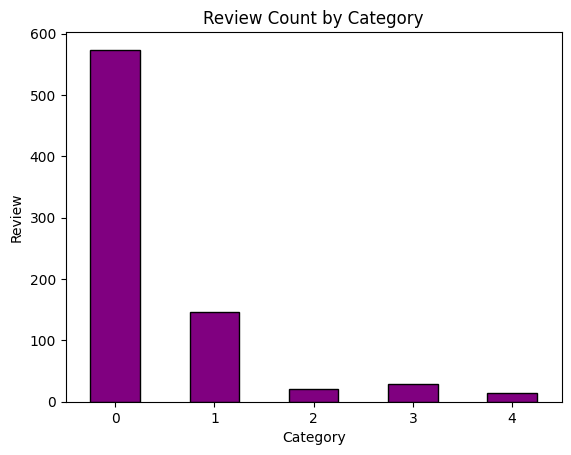

In [61]:
# LSA Model Eval 
# pulling predicted topics from NMF Model 
lsa_predi = [np.argsort(each)[::-1][0] for each in w_lsa]
# adding findings to df 
pt_df2['lsa_predi'] = lsa_predi 
# plotting results of LSA Model 
ax = (pt_df2.groupby('lsa_predi').size()).plot(kind='bar',
                                              stacked=True,
                                              rot=0,
                                               color = '#800080',
                                              title='Review Count by Category',
                                              edgecolor='black')
ax.set_xlabel("Category")
ax.set_ylabel("Review")
display(ax)

In [62]:
# LDA Model 
# this code was based on the code provided in the BTAP repo link above under the "LDA" section
lda_model = LatentDirichletAllocation(n_components = 5, 
                                random_state=1025)
w_lda = lda_model.fit_transform(count_text_vectors)
h_lda = lda_model.components_

In [63]:
display_topics(lda_model, count_text_vectorizer.get_feature_names(),
              no_top_words=10)


Topic 00
  tacos (2.96)
  taco (2.71)
  dont (2.02)
  didnt (1.68)
  like (1.33)
  great (1.31)
  place (1.22)
  food (1.20)
  location (1.11)
  meat (1.09)

Topic 01
  great (4.09)
  food (3.52)
  service (2.50)
  pizza (2.04)
  good (1.56)
  family (1.30)
  place (1.27)
  come (1.09)
  filippis (1.08)
  delicious (1.01)

Topic 02
  food (3.16)
  tacos (2.60)
  order (2.29)
  place (2.03)
  service (1.91)
  good (1.66)
  drive (1.26)
  like (1.25)
  line (1.25)
  time (1.20)

Topic 03
  tacos (8.05)
  adobada (2.39)
  taco (2.13)
  place (1.86)
  asada (1.78)
  el (1.77)
  good (1.77)
  gordo (1.47)
  best (1.44)
  meat (1.37)

Topic 04
  pizza (4.42)
  cheese (2.01)
  order (1.81)
  time (1.52)
  location (1.26)
  sauce (1.17)
  ordered (1.14)
  got (1.09)
  like (1.07)
  good (1.05)


<AxesSubplot: title={'center': 'Review Count by Category'}, xlabel='Category', ylabel='Review'>

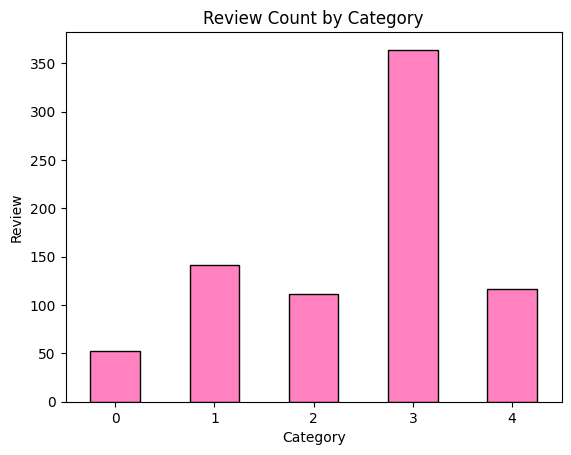

In [64]:
# LDA Model Eval 
# pulling predicted topics from NMF Model 
lda_predi = [np.argsort(each)[::-1][0] for each in w_lda]
# adding findings to df 
pt_df2['lda_predi'] = lda_predi 
# plotting results of LDA Model 
ax = (pt_df2.groupby('lda_predi').size()).plot(kind='bar',
                                              stacked=True,
                                              rot=0,
                                               color = '#FF81C0',
                                              title='Review Count by Category',
                                              edgecolor='black')
ax.set_xlabel("Category")
ax.set_ylabel("Review")
display(ax)

Based on the results obtained for each of the three different topic models (NMF, LSA, and LDA), the most recommendable model is the NMF model. This is the case as the NMF model has a sufficient distribution of the reviews within the topics. This can be noted by looking at each of the graphs associated with each of the models. Additionally, the words associated with each of its topics makes sense within the context of restaurant reviews. 

### Classification Modeling + Evaluations  

In [93]:
# splitting the data based on nmf modeling 
x_train, x_test, y_train, y_test = train_test_split(pt_df['clean'],
                                                    pd.get_dummies(pt_df2['nmf_predi'],
                                                                   prefix='cat_',
                                                                   dtype='float'),
                                                    test_size=0.3,
                                                    random_state=1025)
# using TfidVectorizer to convert docs to a matrix of TF-IDF features
vec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
vec.fit(x_train)
x_train = vec.transform(x_train)
x_test = vec.transform(x_test)

In [94]:
print('Size of Training Data ', x_train.shape[0])
print('Size of Test Data ', x_test.shape[0])

Size of Training Data  549
Size of Test Data  236


Accuracy Score: 0.326271186440678
Classification Report 
               precision    recall  f1-score   support

           0       0.33      1.00      0.49        77
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        28

    accuracy                           0.33       236
   macro avg       0.07      0.20      0.10       236
weighted avg       0.11      0.33      0.16       236

Hamming-Loss Score: 0.2


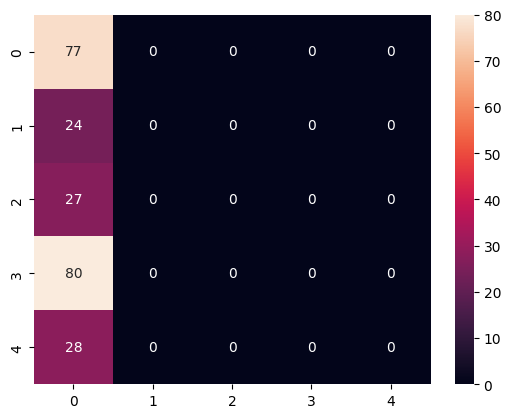

In [107]:
# dummy model (baseline model)
dummy = DummyClassifier(strategy="most_frequent", random_state=1025)
dummy.fit(x_train, y_train)

# Predicting on the test data
y_predi = dummy.predict(x_test)

# confusion matrix + classification report of results 
cm = confusion_matrix(y_test.values.argmax(axis=1), 
                       y_predi.argmax(axis=1))
sns.heatmap(cm, annot=True)
print('Accuracy Score:', accuracy_score(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
print('Classification Report \n', 
       classification_report(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
# hamming score 
print("Hamming-Loss Score:", hamming_loss(y_test, y_predi))

Accuracy Score:  0.614406779661017
Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.43      0.54        77
           1       0.62      0.62      0.62        24
           2       0.47      0.78      0.58        27
           3       0.69      0.68      0.68        80
           4       0.51      0.79      0.62        28

    accuracy                           0.61       236
   macro avg       0.60      0.66      0.61       236
weighted avg       0.65      0.61      0.61       236

Hamming-Loss Score: 0.15423728813559323


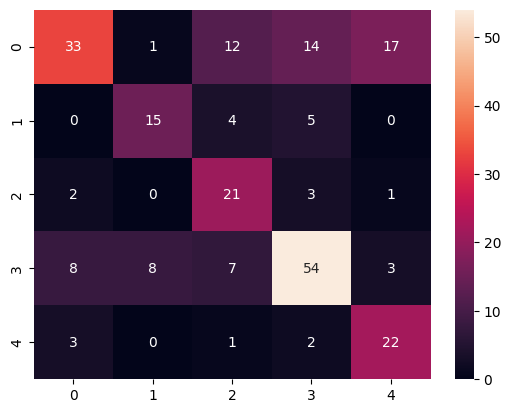

In [119]:
# decision tree model 
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

# Predicting on the test data
y_predi = dt.predict(x_test)

# confusion matrix + classification report of results 
cm = confusion_matrix(y_test.values.argmax(axis=1), 
                       y_predi.argmax(axis=1))
sns.heatmap(cm, annot=True)
print("Accuracy Score: ", accuracy_score(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
print('Classification Report \n', 
       classification_report(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
# hamming score 
print("Hamming-Loss Score:", hamming_loss(y_test, y_predi))

Accuracy Score:  0.635593220338983
Classification Report 
               precision    recall  f1-score   support

           0       0.49      0.99      0.66        77
           1       1.00      0.12      0.22        24
           2       1.00      0.30      0.46        27
           3       0.93      0.65      0.76        80
           4       0.73      0.39      0.51        28

    accuracy                           0.64       236
   macro avg       0.83      0.49      0.52       236
weighted avg       0.78      0.64      0.61       236

Hamming-Loss Score: 0.1152542372881356


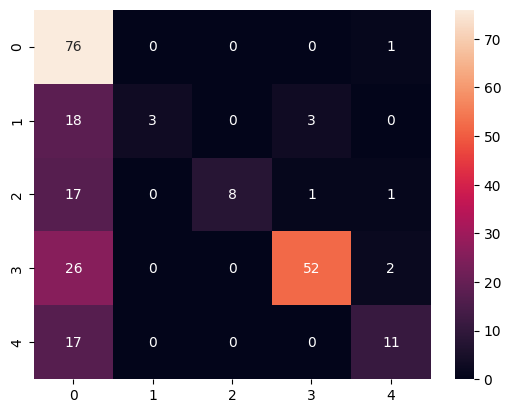

In [113]:
# random forest model 
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc.fit(x_train, y_train)

# Predicting on the test data
y_predi = rfc.predict(x_test)

# confusion matrix + classification report of results 
cm = confusion_matrix(y_test.values.argmax(axis=1), 
                       y_predi.argmax(axis=1))
sns.heatmap(cm, annot=True)
print("Accuracy Score: ", accuracy_score(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
print('Classification Report \n', 
       classification_report(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
# hamming score 
print("Hamming-Loss Score:", hamming_loss(y_test, y_predi))

Accuracy Score:  0.711864406779661
Classification Report 
               precision    recall  f1-score   support

           0       0.58      0.90      0.70        77
           1       0.90      0.79      0.84        24
           2       0.84      0.59      0.70        27
           3       0.88      0.56      0.69        80
           4       0.73      0.68      0.70        28

    accuracy                           0.71       236
   macro avg       0.79      0.70      0.73       236
weighted avg       0.76      0.71      0.71       236

Hamming-Loss Score: 0.1016949152542373


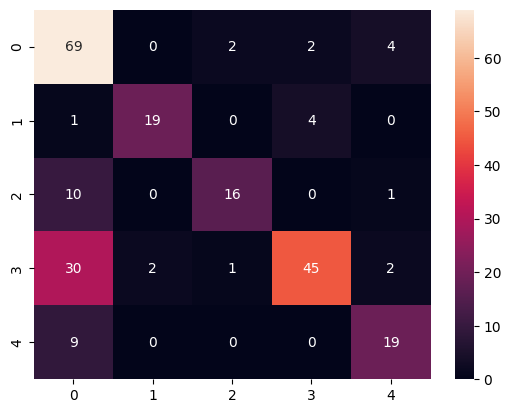

In [106]:
# knn model 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# Predicting on the test data
y_predi = knn.predict(x_test)

# confusion matrix + classification report of results 
cm = confusion_matrix(y_test.values.argmax(axis=1), 
                       y_predi.argmax(axis=1))
sns.heatmap(cm, annot=True)
print("Accuracy Score: ", accuracy_score(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
print('Classification Report \n', 
       classification_report(y_test.values.argmax(axis=1), 
                             y_predi.argmax(axis=1)))
# hamming score 
print("Hamming-Loss Score:", hamming_loss(y_test, y_predi))

The results obtained for each of the four classification models (Baseline, Decision Tree, Random Forest, and KNN) indicate that the most recommendable model for restaurants would be the k-nearest neighbor (KNN) model. This deduction was made based on each of the model’s accuracy scores and Hamming-Loss score. Furthermore, the precision, recall, and f1 scores for each of the predicted NMF topics within each of classification models were analyzed to further ensure that the KNN model was sufficient. Model accuracy was chosen as one of the evaluation metrics because of its importance in helping gauge a model’s ability to process, understand, and predict. When looking at the metric of accuracy, a higher score indicates a better model. The Baseline model obtained an accuracy score of 0.33. The Decision Tree model obtained an accuracy score of 0.61. The Random Forest model obtained an accuracy score of 0.63. The KNN model obtained an accuracy score of  0.71. Based on the accuracy scores, it can be noted that the KNN model had the highest accuracy (0.71) while the baseline model had the lowest accuracy (0.33). The difference in the accuracy between the baseline model and the KNN model is definitely something to note. The next metric used to verify which model would be recommendable was the Hamming-Loss score. The Hamming-Loss score is the fraction of labels that are incorrectly predicted. This score can be helpful when dealing with multi-level classification. This is important as  the current machine learning task deals with multi-level classification. It should be noted that the Hamming-Loss score is scored on a scale of 0 to 1, where values closer to zero are better. When reviewing the Hamming-Loss scores, unsurprisingly, the KNN model had the lowest Hamming-Loss score (0.10). This indicates that it had the least amount of errors and therefore was the most recommendable model. On the other hand, the baseline model had the highest Hamming-Loss score (0.2), indicating that the model had many errors. Furthermore, looking at the precision, recall, and f1 scores for each of the topics within the models also indicates how well the models predicted for each of the topics. With regards to all of these factors, it can be noted that the KNN model is the most recommendable model.

## References 

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python. O'Reilly.

Bressler, N. (2023, March 23). How to Check the Accuracy of Your Machine Learning Model. Deepchecks. https://deepchecks.com/how-to-check-the-accuracy-of-your-machine-learning-model/#:~:text=We%20calculate%20accuracy%20by%20dividing,accuracy%20on%20this%20multiclass%20problem.

Li, S. (2021, December 8). A Complete Exploratory Data Analysis and Visualization for Text Data. Medium. https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

Mohajon, J. (2021, December 14). Confusion Matrix for Your Multi-Class Machine Learning Model. Medium. https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

Multilabel-indicator is not supported for confusion matrix. (n.d.). Stack Overflow. https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix

Multiclass Receiver Operating Characteristic (ROC). (n.d.). Scikit-learn. https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Pandas Extract Number from String. (n.d.). Stack Overflow. https://stackoverflow.com/questions/37683558/pandas-extract-number-from-string

Python - y should be a 1d array, got an array of shape instead. (n.d.). Stack Overflow. https://stackoverflow.com/questions/65167879/python-y-should-be-a-1d-array-got-an-array-of-shape-instead

sklearn.metrics.hamming_loss. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html
